<a href="https://colab.research.google.com/github/YoonhoNam/hufsclass/blob/master/ch3_04_Concise_Implementation_of_Softmax_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.7. Concise Implementation of Softmax Regression

이번 실습은 pytorch에서 제공하고 있는 image dataset인 fashion-mnist를 이용하여 softmax regression model을 학습시켜 보는 것입니다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

colab을 사용하는 경우에는 google drive를 mount하도록 합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
root = '/content/drive/My Drive/hufs'

## Getting the Dataset

데이터를 가져오는 것은 ch3의 3번째 실습의 내용과 동일합니다.

In [3]:
pil2tensor = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root, train=True, transform=pil2tensor, target_transform=None, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root, train=False, transform=pil2tensor, target_transform=None, download=True)
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

## The Model, Loss, Data_loader and parameters
- output이 여러 개인 것과 loss function이 cross entropy loss라는 것을 제외하면 linear regression에서 했던 것과 거의 유사합니다. 
- test data에 대해 test_iter를 만들었고, test_iter는 shuffle을 False로 한 것이 train_iter와의 차이점입니다.

In [4]:
# setting hyper-parameters
batch_size = 256
learning_rate = 0.03
num_epochs = 10
num_workers = 0

# defining model
net = nn.Linear(28*28,10) # model
torch.nn.init.normal_(net.weight,std=0.01) # parameter initialization
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(net.parameters(),lr=learning_rate) # sgd

# defining data_iter, linreg. model, loss, sgd
train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)

net

Linear(in_features=784, out_features=10, bias=True)

## Model Training
model을 훈련하면서 train loss, train accuracy, test accuracy를 관찰합니다.
바로 위의 cell의 hyperparameter들을 바꿔가면서 결과를 비교해 봅니다.

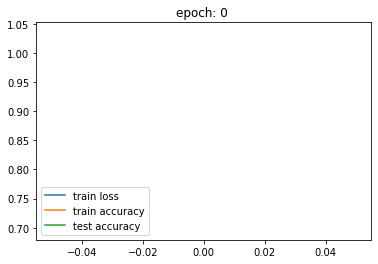

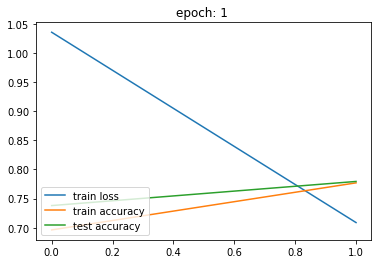

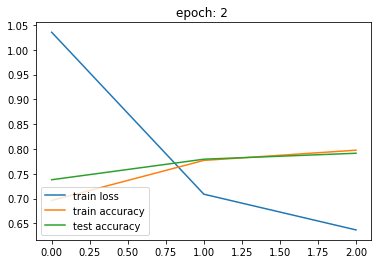

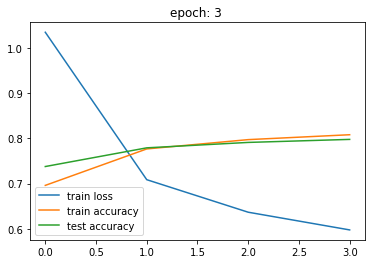

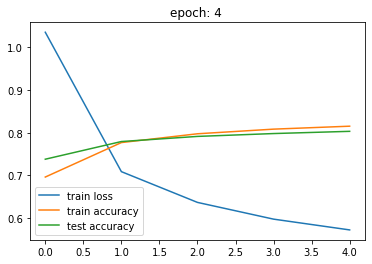

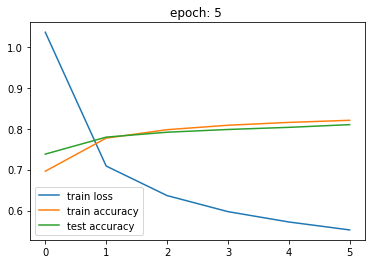

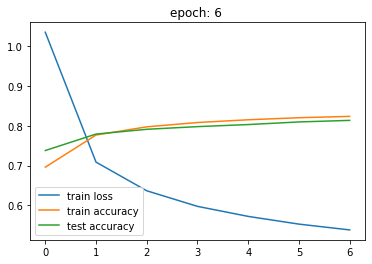

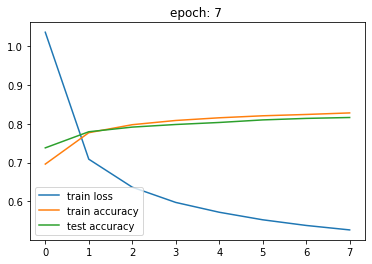

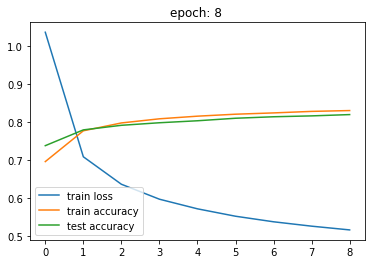

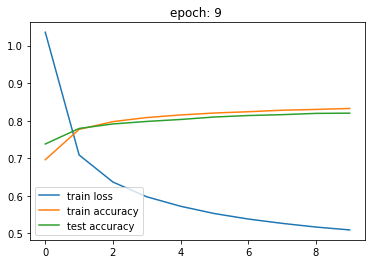

In [5]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_test = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X=X.view(-1,784)
    y_hat=net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()  

  loss_train = np.append(loss_train,l_epoch.detach().numpy()/i)
  accs_train = np.append(accs_train,correct/60000.)

  correct = 0
  for X,y in test_iter:
    y_hat = net(X.view(-1,784))
    correct += (y_hat.argmax(dim=1)==y).sum()
  accs_test = np.append(accs_test,correct/10000.)

  plt.plot(loss_train,label='train loss')
  plt.plot(accs_train,label='train accuracy')
  plt.plot(accs_test,label='test accuracy')
  plt.legend(loc='lower left')
  plt.title('epoch: %d '%(epoch))
  plt.pause(.0001)



## Prediction

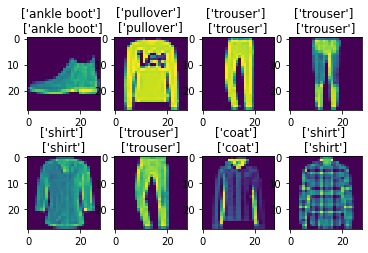

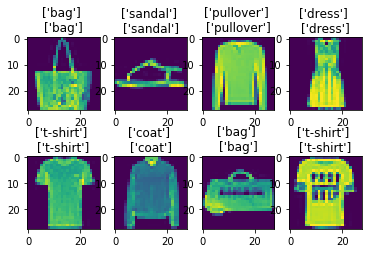

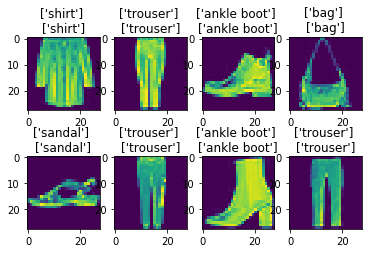

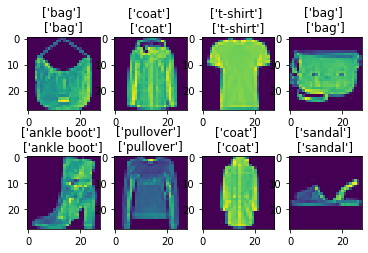

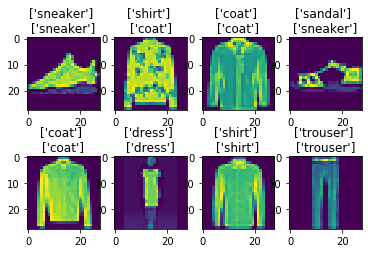

In [6]:
i = 0
for X,y in test_iter:
  i=i+1
  y_hat = net(X.view(-1,784))    
  y_hat = y_hat.argmax(dim=1)
  for n in range(8):
    plt.subplot(241+n)
    plt.imshow(X[n].squeeze())
    plt.title('%s \n%s'%(get_fashion_mnist_labels([y[n]]),get_fashion_mnist_labels([y_hat[n]])))
  plt.pause(.0001)
  if i>4:
     break

## Softmax
학습된 model에 test set의 데이터 중 하나를 가져와서 예측값을 얻고 그 값들을 살펴봅시다.

y1 = 
 tensor([[ 0.9350, -1.2173,  3.2523, -0.3038,  4.6189, -1.6754,  3.1151, -6.3197,
          1.5537, -3.2411]], grad_fn=<AddmmBackward>)


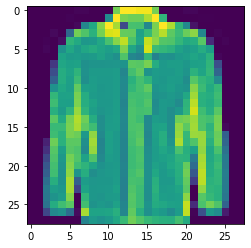

In [7]:
X1 = X[2]
X1.shape
y1 = net(X1.view(-1,784))
print('y1 = \n',y1)
plt.imshow(X1.squeeze())

fully connected layer의 output은 probability의 형태가 아닙니다. 우리는 softmax를 통해 output을 probability의 형태로 출력할 수 있습니다.

In [8]:
y1_softmax = y1.softmax(dim=1)
print('y1_softmax = \n',y1_softmax)

print('\nsum of y1_softmax = \n',torch.sum(y1_softmax))

print('\n 100 x y1_softmax = \n',(100*y1_softmax).long())


y1_softmax = 
 tensor([[1.6091e-02, 1.8701e-03, 1.6329e-01, 4.6621e-03, 6.4042e-01, 1.1828e-03,
         1.4235e-01, 1.1374e-05, 2.9873e-02, 2.4713e-04]],
       grad_fn=<SoftmaxBackward>)

sum of y1_softmax = 
 tensor(1.0000, grad_fn=<SumBackward0>)

 100 x y1_softmax = 
 tensor([[ 1,  0, 16,  0, 64,  0, 14,  0,  2,  0]])


우리는 예측결과를 다음과 같이 확률과 함께 출력해 줄 수 있습니다.

In [9]:
print('predicted: %s with probability %f'%(get_fashion_mnist_labels([y1_softmax.argmax(dim=1)]), y1_softmax.max()))

predicted: ['coat'] with probability 0.640422
